<a href="https://colab.research.google.com/github/iMvijay23/clsp_finder/blob/main/code/IRGPTtitleandsummary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GPT title generation 

In [ ]:
pip install openai

In [1]:

import json
# Read the JSON data from the file
with open("papers_summaries_2.json", "r") as f:
    data = json.load(f)


In [26]:
for each in data:
  print(each.keys())
  authorsl = each["authors"]
  #print(authorsl)
  authors = ""
  for at in authorsl:
    authors+=at['name'] + ", "
  prompt = f"""
Given the following information about a research paper:

- Summary: { each['Summary']}
- FocusArea: {each['focusArea']}
- Authors: {authors[:-2]}
- Year: {each['year']}
- URL: {each['url']}

Please generate a suitable title for this paper.
"""
  print(prompt)
  break

dict_keys(['paperId', 'externalIds', 'url', 'title', 'venue', 'year', 'publicationTypes', 'publicationDate', 'journal', 'authors', 'bibtex', 'Summary', 'focusArea', 'gpttitle'])

Given the following information about a research paper:

- Summary: 1. Introduction

The paper provides an overview of the design trade-offs that need to be considered when designing sensor systems. It covers various topics such as power consumption, bandwidth, and data storage. The paper also discusses the trade-offs between different types of sensors.

2. Power Consumption

One of the main trade-offs in sensor design is power consumption. Sensors need to be designed to consume as little power as possible while still providing accurate data. Various techniques can be used to reduce power consumption, such as using lower power sensors or designing custom power management circuitry.

3. Bandwidth

Another trade-off in sensor design is bandwidth. Sensor data needs to be transmitted quickly and efficiently to the

In [32]:
import openai
import json
from tqdm import tqdm

# Replace with your OpenAI API key
openai.api_key = 'api key'


def generate_code(prompt):
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=prompt,
        max_tokens=100,
        n=1,
        stop=None,
        temperature=0.5
    )
    return response.choices[0].text.strip()

for i, each in enumerate(tqdm(data, desc="Processing papers")):
    authorsl = each["authors"]
    #print(authorsl)
    authors = ""
    for at in authorsl:
      authors+=at['name'] + ", "
    prompt = f"""
Given the following information about a research paper:

- Summary: { each['Summary']}
- FocusArea: {each['focusArea']}
- Authors: {authors[:-2]}
- Year: {each['year']}
- URL: {each['url']}

Please generate a suitable title for this paper.
"""
    

    c1 = generate_code(prompt)
    #print(c1)
    

    data[i]["gpttitle"] = c1
    


# Save the updated data to a new JSON file
with open("papers_summaries_2.json", "w") as f:
    json.dump(data, f, indent=4)


Processing papers: 100%|██████████| 3131/3131 [2:01:58<00:00,  2.34s/it]


In [ ]:
pip install transformers


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("t5-base")

model = AutoModelForSeq2SeqLM.from_pretrained("t5-base")

In [ ]:
with open("papers_titlesgpt.json", "w") as f:
    json.dump(data, f, indent=4)

In [25]:

for i, each in enumerate(data):

    authorsl = each["authors"]
    #print(authorsl)
    authors = ""
    for at in authorsl:
      authors+=at['name'] + ", "
    prompt = f"""
Given the following information about a research paper, generate only a paper title:

- Summary: { each['Summary']}
- FocusArea: {each['focusArea']}
- Authors: {authors[:-2]}
- Year: {each['year']}
- URL: {each['url']}

Please generate a suitable title for this paper.
    """

    inputs = tokenizer.encode(prompt, return_tensors="pt", max_length=100, truncation=True)

    outputs = model.generate(inputs, max_length=80, min_length=10, length_penalty=2.0, num_beams=4, early_stopping=True)


    title = tokenizer.decode(outputs[0])

    each['gpttitle'] = title.strip()
    print(each['gpttitle'])

    break

    with open('papers_summaries_2.json', 'w') as file:
      json.dump(data, file)


  
  

<pad> False spokesman: False</s>


In [ ]:
!pip install sentence-transformers matplotlib sklearn pandas numpy seaborn


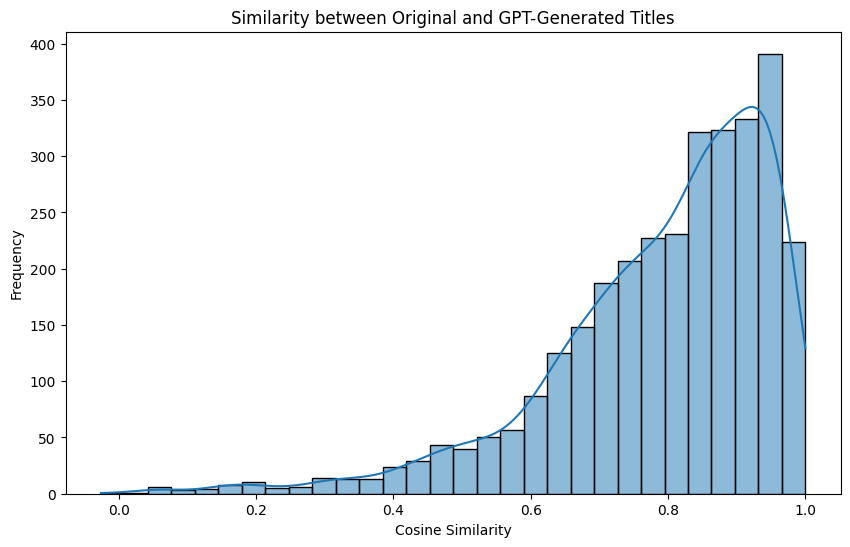

In [34]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_json('papers_summaries_2.json')

model = SentenceTransformer('all-MiniLM-L6-v2')

df['original_embedding'] = df['title'].apply(lambda x: model.encode(x))
df['gpt_embedding'] = df['gpttitle'].apply(lambda x: model.encode(x))

df['similarity'] = df.apply(lambda row: cosine_similarity([row['original_embedding']], [row['gpt_embedding']])[0][0], axis=1)

# Plot the similarity
plt.figure(figsize=(10,6))
sns.histplot(df['similarity'], bins=30, kde=True)
plt.title('Similarity between Original and GPT-Generated Titles')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()


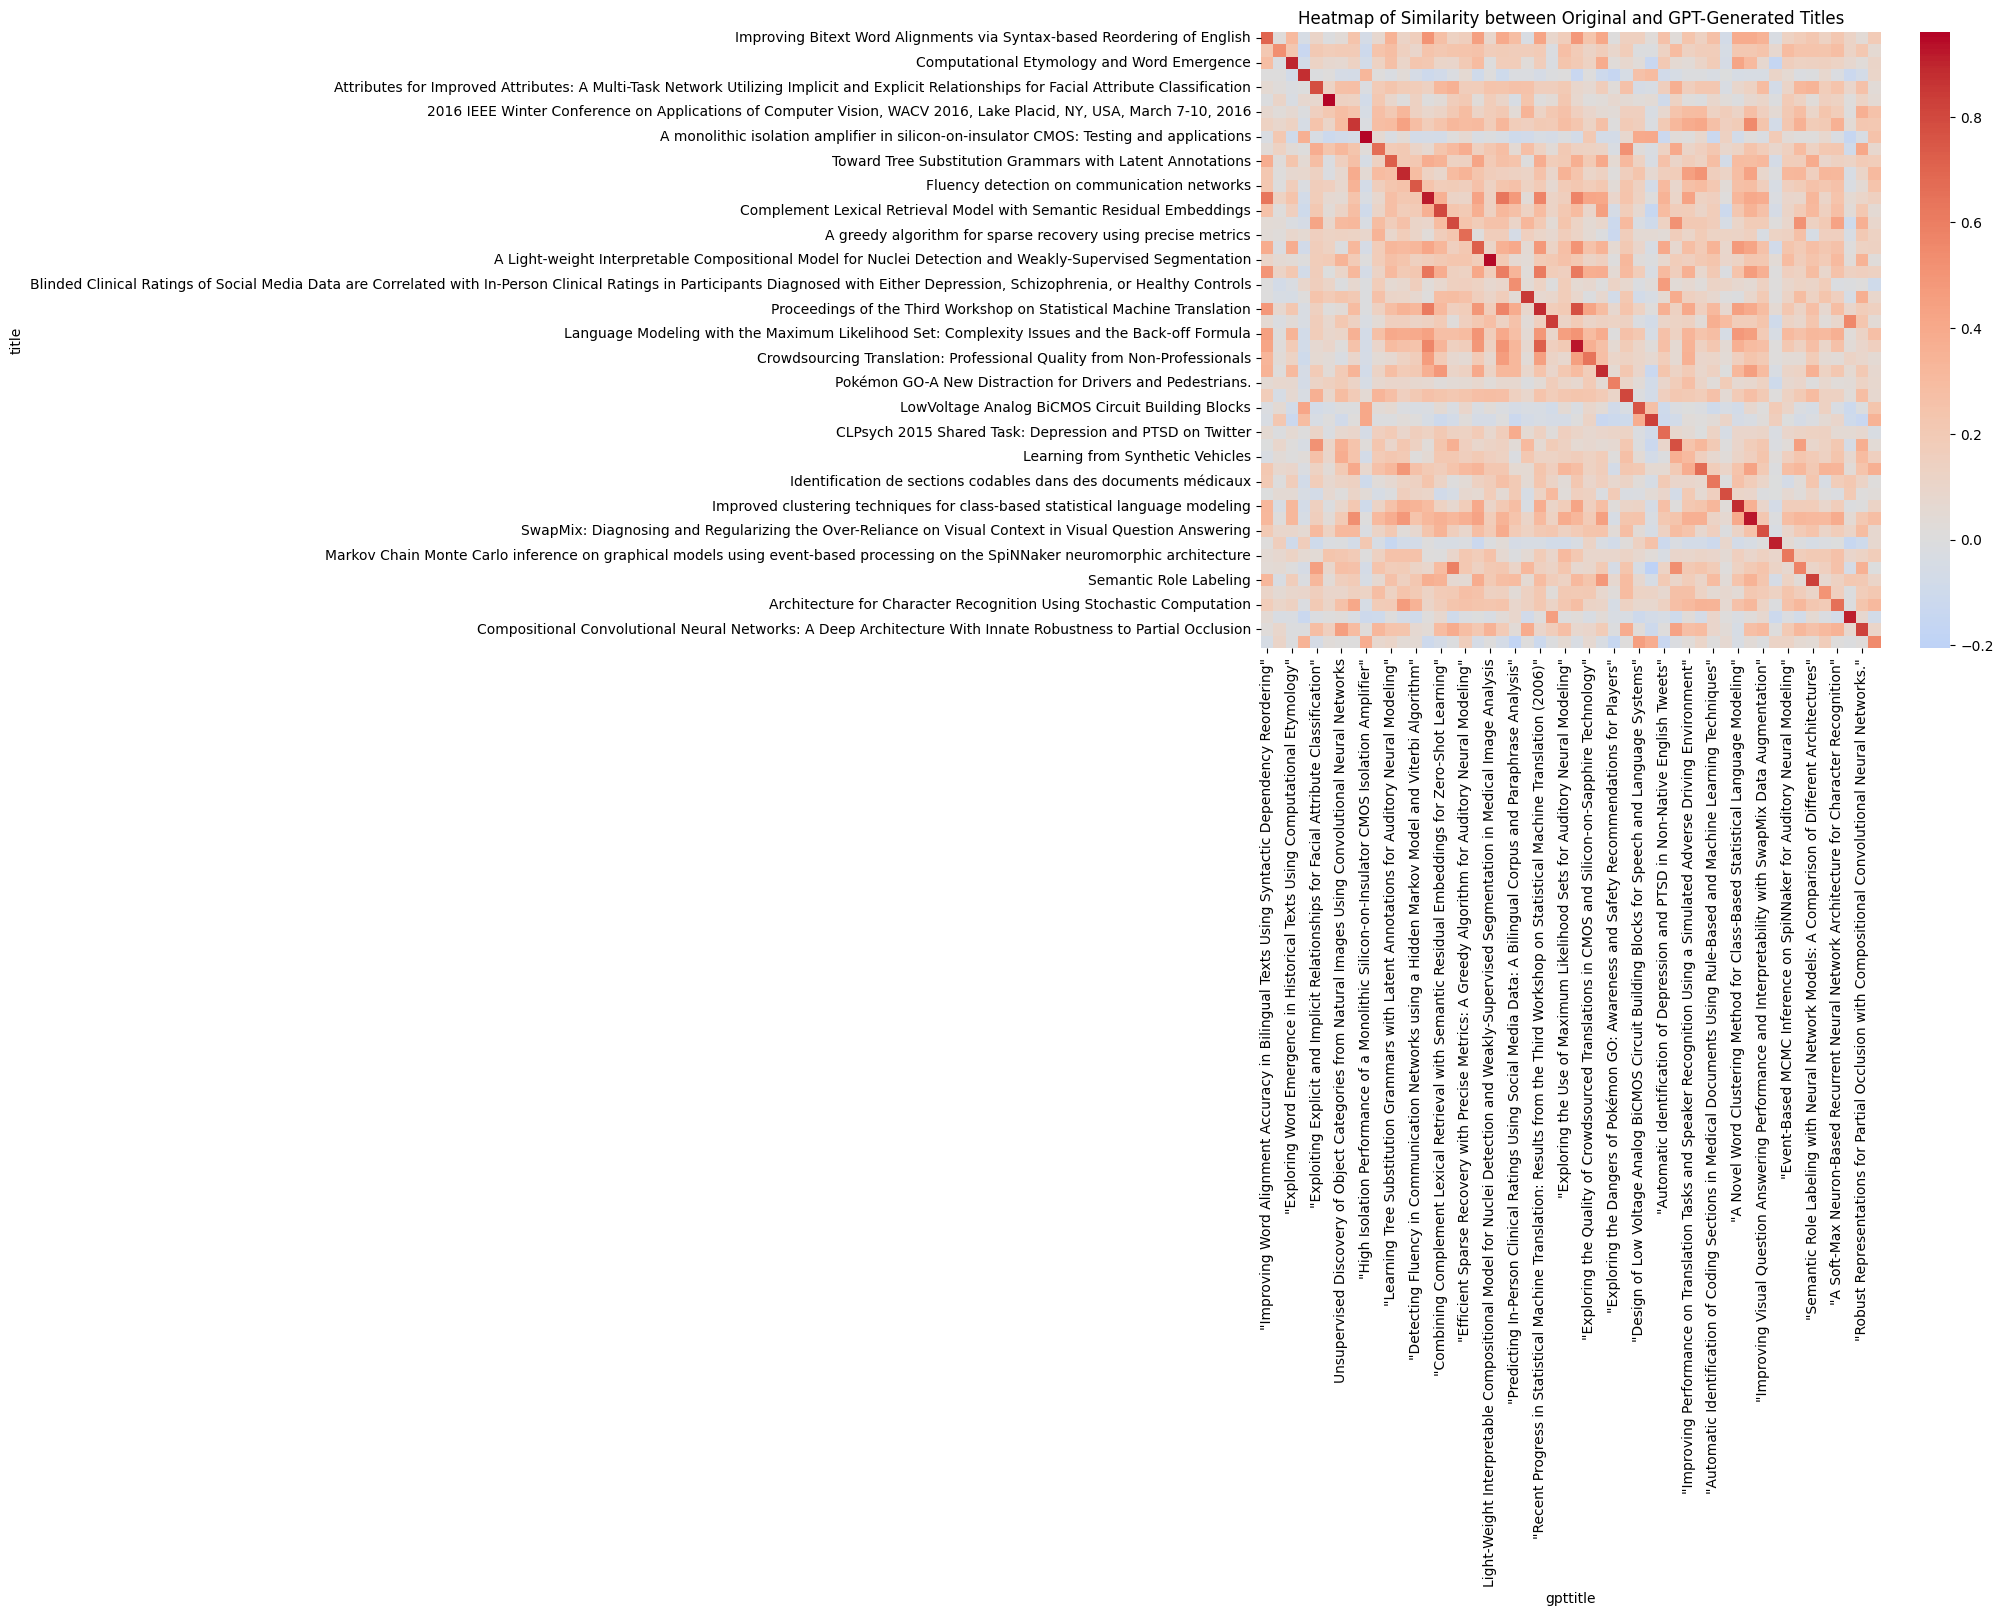

In [36]:
import seaborn as sns

# Sample a subset of instances
subset_size = 50
subset_df = df.sample(subset_size)

# Calculate similarity matrix
similarity_matrix = cosine_similarity(np.stack(subset_df['original_embedding']), np.stack(subset_df['gpt_embedding']))

# Create a DataFrame for the similarity matrix
similarity_df = pd.DataFrame(similarity_matrix, index=subset_df['title'], columns=subset_df['gpttitle'])

# Plot a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, cmap='coolwarm', center=0)
plt.title('Heatmap of Similarity between Original and GPT-Generated Titles')
plt.show()


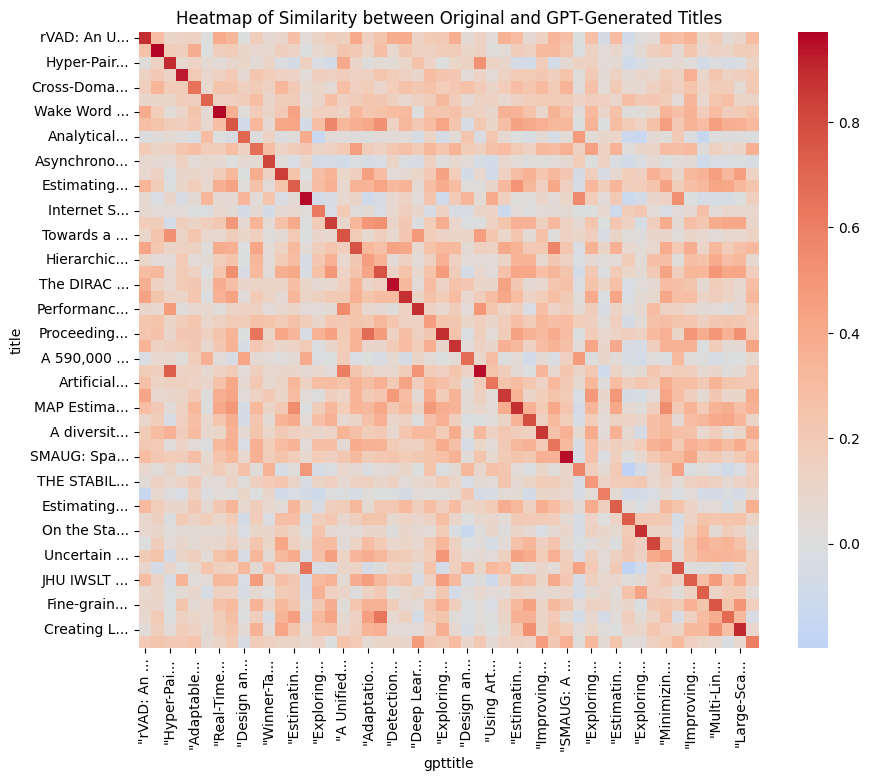

In [47]:
import seaborn as sns

# Sample a subset of instances
subset_size = 50
subset_df = df.sample(subset_size)

# Calculate similarity matrix
similarity_matrix = cosine_similarity(np.stack(subset_df['original_embedding']), np.stack(subset_df['gpt_embedding']))

# Function to truncate text
def truncate_text(text, max_length=10):
    if len(text) > max_length:
        return text[:max_length] + '...'
    return text

# Apply truncation to titles
subset_df['title'] = subset_df['title'].apply(truncate_text)
subset_df['gpttitle'] = subset_df['gpttitle'].apply(truncate_text)

# Create a DataFrame for the similarity matrix
similarity_df = pd.DataFrame(similarity_matrix, index=subset_df['title'], columns=subset_df['gpttitle'])

# Plot a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, cmap='coolwarm', center=0)
plt.title('Heatmap of Similarity between Original and GPT-Generated Titles')
plt.show()


Summaries, Clustering and plots


#Summary generation

In [ ]:

import openai
import json

# Replace with your OpenAI API key
openai.api_key = 'your key '

# Read the JSON data from the file
with open("papers.json", "r") as f:
    data = json.load(f)

def generate_code(prompt):
    response = openai.Completion.create(
        engine="text-davinci-002",
        prompt=prompt,
        max_tokens=3000,
        n=1,
        stop=None,
        temperature=0.5
    )
    return response.choices[0].text.strip()



for i, example in enumerate(data):
    prompt = "Write a paper summary for the paper:\n"
    urltoken = example["url"]
    titletoken = example["title"]
    prompt+=urltoken
    prompt+="\n"
    prompt+=titletoken
    #Summary = generate_code(prompt)
    
    data[i]["Summary"] = Summary

# Save the updated data to a new JSON file
with open("papers_summaries.json", "w") as f:
    json.dump(data, f, indent=4)


##clustering

In [ ]:
import json

# Load data from JSON file
with open('papers_summaries.json') as f:
    data = json.load(f)

# Extract summaries and paperIds
summaries = [d['Summary'] for d in data]
paper_ids = [d['paperId'] for d in data]


In [ ]:
print(len(summaries))


3131


In [ ]:
print(len(paper_ids))

3131


##embeddings


In [ ]:
pip install transformers

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load pre-trained model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [ ]:
model.device("cuda")
tokenizer.device("cuda")

In [ ]:
def get_embedding(text, chunk_size=512):
    # Tokenize input text
    tokens = tokenizer.encode(text, truncation=False)

    # Split tokens into chunks
    chunks = [tokens[i:i+chunk_size] for i in range(0, len(tokens), chunk_size)]

    embeddings = []
    for chunk in chunks:
        # Convert to torch tensors
        input_ids = torch.tensor([chunk])
        
        # Get the model outputs
        with torch.no_grad():
            outputs = model(input_ids)
        
        # Get the embeddings from the last hidden state
        embeddings_chunk = outputs[0].mean(1).squeeze()
        embeddings.append(embeddings_chunk)
    
    # Combine chunk embeddings
    embeddings = torch.stack(embeddings).mean(0)

    return embeddings


In [ ]:
bert_embeddings = [get_embedding(summary) for summary in summaries]

In [ ]:
print(bert_embeddings[0])

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Load your embeddings and summaries here
embeddings = np.array(bert_embeddings)  # replace with your list of embeddings
summaries = summaries  # replace with your list of summaries

# Step 2: Cluster the embeddings
num_clusters = 15  # replace with your desired number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(embeddings)
labels = kmeans.labels_

# Step 3: Group summaries based on their cluster IDs
clusters = {i: [] for i in range(num_clusters)}
for i, label in enumerate(labels):
    clusters[label].append(summaries[i])

with open("clusters_sum.json", "w") as f:
  json.dump(clusters, f)

# Step 4 and 5: Run LDA on each cluster to get topics, and choose topics as cluster names
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

cluster_names = {}
for i in range(num_clusters):
    doc_clean = [clean(doc).split() for doc in clusters[i]]
    dictionary = corpora.Dictionary(doc_clean)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    ldamodel = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)
    cluster

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Assume `embeddings` is a list of your BERT embeddings

# Convert list of tensors to numpy array
embeddings = np.array([e.numpy() for e in bert_embeddings])

# Dimensionality Reduction
pca = PCA(n_components=50)  # Or any number that suits your data
embeddings_pca = pca.fit_transform(embeddings)

# Clustering
kmeans = KMeans(n_clusters=10)  # Or any number that suits your data
clusters = kmeans.fit_predict(embeddings_pca)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
print(len(clusters))

3131


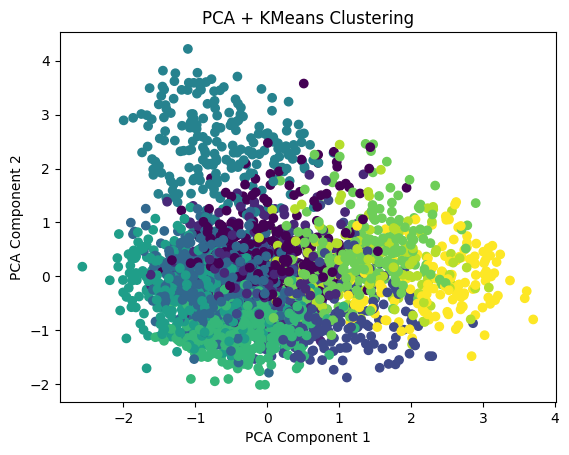

In [ ]:
import matplotlib.pyplot as plt

# Visualize clusters in 2D
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=clusters)
plt.title('PCA + KMeans Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


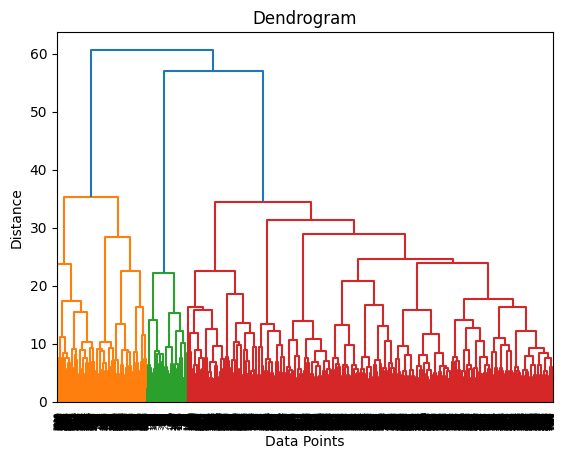

In [ ]:
import scipy.cluster.hierarchy as shc

# Perform hierarchical clustering
dendrogram = shc.dendrogram(shc.linkage(embeddings_pca, method='ward'))

# Visualize dendrogram
plt.title('Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()


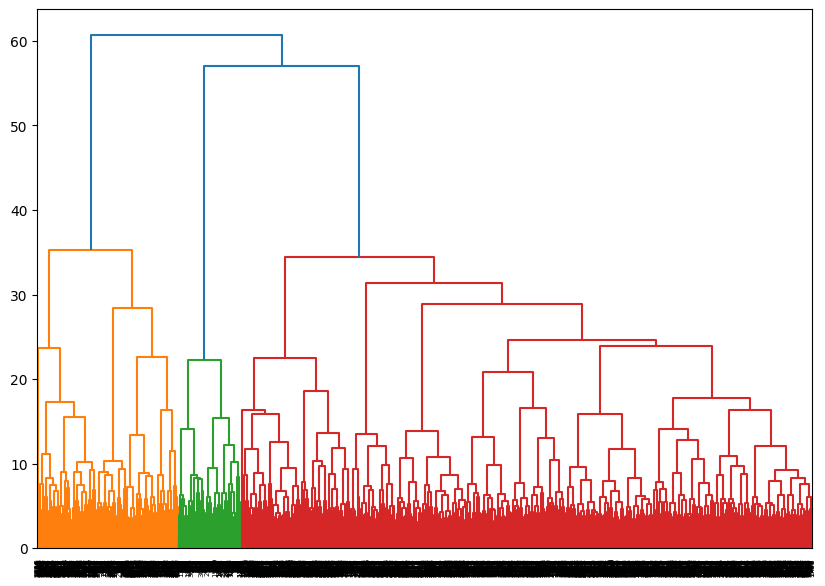

In [ ]:
import scipy.cluster.hierarchy as shc

# Compute the linkage matrix
linkage_matrix = shc.linkage(embeddings_pca, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram = shc.dendrogram(linkage_matrix)

# Draw a horizontal line to estimate the number of clusters
plt.axhline(y=100, color='r', linestyle='--')

# Show the plot
plt.show()


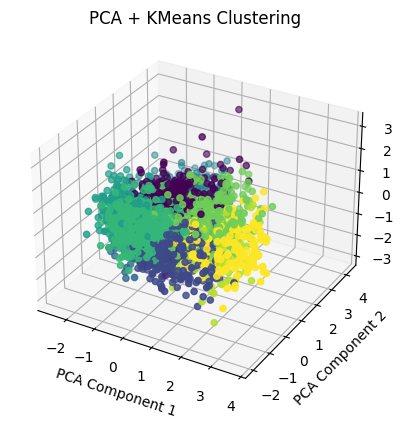

In [ ]:
from mpl_toolkits import mplot3d

# Visualize clusters in 3D
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(embeddings_pca[:, 0], embeddings_pca[:, 1], embeddings_pca[:, 2], c=clusters)
ax.set_title('PCA + KMeans Clustering')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.show()


In [ ]:
import plotly.graph_objs as go
import numpy as np

# Generate some random data
np.random.seed(42)
x = np.random.randn(1000)
y = np.random.randn(1000)

# Create the plotly figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y, mode='markers'))

# Add zooming and panning functionality
fig.update_layout(
    dragmode='zoom',
    xaxis=dict(title='X-axis'),
    yaxis=dict(title='Y-axis'),
    title='Zoomable Scatter Plot'
)

# Show the plot
fig.show()


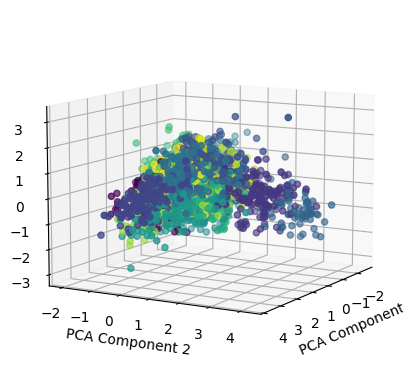

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
ax.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], embeddings_pca[:, 2], c=clusters)

# Set the initial viewing angle
ax.view_init(elev=10, azim=30)

# Set the axis labels
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

# Show the plot
plt.show()


In [ ]:
cluster_dict = {}
for i, cluster_id in enumerate(clusters):
    if cluster_id not in cluster_dict:
        cluster_dict[int(cluster_id)] = []
    summary_dict = {'paper_id': paper_ids[i], 'summary': summaries[i]}
    cluster_dict[cluster_id].append(summary_dict)

# Save the dictionary as a JSON file
with open('clustered_summaries_appended.json', 'w') as outfile:
    json.dump(cluster_dict, outfile)

In [ ]:
import json

# Create a list of dictionaries containing the cluster id, paper id, and summary
results = []
for i, cluster in enumerate(clusters):
    results.append({
        'cluster_id': int(cluster),
        'paper_id': data[i]['paperId'],
        'summary': data[i]['Summary']
    })

# Save the results as a JSON file
with open('results_nonape.json', 'w') as f:
    json.dump(results, f)

In [ ]:
import json
import gensim
from gensim import corpora
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
import string

# Load JSON
with open('results_nonape.json') as f:
    data = json.load(f)

with open('papers_summaries.json') as f:
    datas = json.load(f)
# Extract summaries
for cluster in range(10):
    summaries = [sum['title'] for sum in datas for cls in data if cls['cluster_id'] == cluster and cls["paper_id"] == sum["paperId"]]

    # Define the text cleaning function
    stop = set(stopwords.words('english'))
    exclude = set(string.punctuation)
    lemma = WordNetLemmatizer()

    def clean(doc):
        stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
        punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
        normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
        return normalized

    # Apply the cleaning function to each summary
    clean_summaries = [clean(summary).split() for summary in summaries]

    # Creating the term dictionary of our courpus, where every unique term is assigned an index
    dictionary = corpora.Dictionary(clean_summaries)

    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above
    doc_term_matrix = [dictionary.doc2bow(summary) for summary in clean_summaries]

    # Creating the object for LDA model using gensim library
    Lda = gensim.models.ldamodel.LdaModel

    # Running and Training LDA model on the document term matrix
    ldamodel = Lda(doc_term_matrix, num_topics=15, id2word = dictionary, passes=50)

    # Print the topics
    print(ldamodel.print_topics(num_topics=3, num_words=5))
    print('===============================')
    print("cluster above is :",cluster)
    print('===============================')
    
topics= ["ASR & Multilingual NLP"]
# Load data from JSON file
#with open('papers_summaries.json') as f:
#    data1 = json.load(f)
#
#
#for i in range(20):
#    for example in data1:
#        for cls in data:
#            if cls["cluster_id"] == 0 and cls["paper_id"] == example["paperId"]: 
#                example["focusArea"] = "ASR & Multilingual NLP"
#    
#with open("papers_summaries.json", "w") as f:
#    json.dump(data1, f, indent=4)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


[(8, '0.019*"system" + 0.013*"data" + 0.013*"image" + 0.013*"space" + 0.013*"challenge"'), (0, '0.025*"speech" + 0.025*"adversarial" + 0.018*"recognition" + 0.015*"augmentation" + 0.014*"using"'), (3, '0.025*"detection" + 0.018*"network" + 0.018*"model" + 0.018*"object" + 0.011*"multistream"')]
cluster above is : 0
[(7, '0.019*"translation" + 0.017*"identification" + 0.017*"task" + 0.017*"biomimetic" + 0.017*"recognition"'), (9, '0.052*"speaker" + 0.041*"endtoend" + 0.018*"translation" + 0.018*"neural" + 0.018*"embeddings"'), (8, '0.088*"speech" + 0.052*"recognition" + 0.025*"language" + 0.024*"system" + 0.016*"large"')]
cluster above is : 1
[(12, '0.024*"auditory" + 0.024*"model" + 0.018*"neural" + 0.012*"machine" + 0.012*"speaker"'), (14, '0.012*"speech" + 0.012*"recognition" + 0.011*"rate" + 0.011*"performance" + 0.011*"decoding"'), (2, '0.035*"speech" + 0.031*"recognition" + 0.030*"modeling" + 0.021*"neural" + 0.021*"language"')]
cluster above is : 2
[(9, '0.027*"using" + 0.023*"re

In [ ]:
 topics =["System Challenges and Image Data"
, "Speech Recognition and Adversarial Augmentation"
, "Neural Network Models and Object Detection"
, "Translation Tasks and Speaker Recognition"
, "Speech and Language Systems"
, "Auditory Neural Modeling"
, "Adaptation and Feature Retrieval"
, "CMOS and Silicon-on-Sapphire Technology"
, "Adversarial Learning and Robustness"
, "Bilingual Corpus and Paraphrase Analysis"]

# Load data from JSON file

for i in range(10):
    for cls in data:
        if cls['cluster_id'] == i:
            for sum in datas:
                if cls["paper_id"] == sum["paperId"]:
                    sum["focusArea"] = topics[i]

with open("papers_summaries.json", "w") as f:
    json.dump(datas, f, indent=4)
